In [61]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
from torch.optim import Adam

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 64
BATCH_SIZE = 128

T = 300

beta = torch.linspace(0.0001, 0.02, T)

alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, axis=0)
alpha_bar_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)

sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)

posterior_variance = beta * (1. - alpha_bar_prev) / (1. - alpha_bar)

In [63]:
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = get_index_from_list(sqrt_alpha_bar, t, x_0.shape)
    sqrt_one_minus_alpha_bar_t = get_index_from_list(
        sqrt_one_minus_alpha_bar, t, x_0.shape
    )
    return (sqrt_alpha_bar_t.to(device) * x_0.to(device)
            + sqrt_one_minus_alpha_bar_t.to(device) * noise.to(device), noise.to(device))

In [64]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

def load_transformed_dataset(dataset):
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(), 
            transforms.Lambda(lambda t: (t * 2) - 1)
        ]
    )

    return dataset(root='.', download=True, transform=data_transform)


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [65]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class Unet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, image_size: int, image_channels: int):
        super().__init__()
        down_channels = (image_size, image_size * 2, image_size * 4, image_size * 8)
        up_channels = down_channels[::-1]
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) 
                                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
                                  for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [66]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [67]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    beta_t = get_index_from_list(beta, t, x.shape)
    sqrt_one_minus_alpha_bar_t = get_index_from_list(
        sqrt_one_minus_alpha_bar, t, x.shape
    )
    sqrt_recip_alpha_t = get_index_from_list(sqrt_recip_alpha, t, x.shape)

    model_mean = sqrt_recip_alpha_t * (
        x - beta_t * model(x, t) / sqrt_one_minus_alpha_bar_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(1, 1))
    plt.axis('off')

    for i in range(T - 1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)

    show_tensor_image(img.detach().cpu())
    plt.show()  

In [68]:
data_set = load_transformed_dataset(torchvision.datasets.Flowers102)

dataloader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [69]:
model = Unet(
    image_size=64,
    image_channels=3
).to(device)

optimizer = Adam(model.parameters(), lr=1E-3)

Epoch 0 | Loss: 0.5926533937454224 


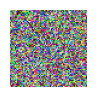

Epoch 1 | Loss: 0.41023021936416626 


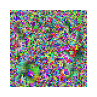

Epoch 2 | Loss: 0.36013638973236084 


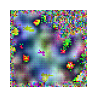

Epoch 3 | Loss: 0.3292575478553772 


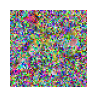

Epoch 4 | Loss: 0.2916184663772583 


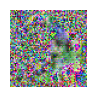

Epoch 5 | Loss: 0.28503695130348206 


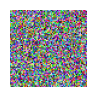

Epoch 6 | Loss: 0.2810114026069641 


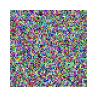

Epoch 7 | Loss: 0.31527096033096313 


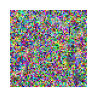

Epoch 8 | Loss: 0.29816508293151855 


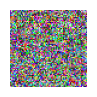

Epoch 9 | Loss: 0.29826512932777405 


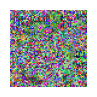

Epoch 10 | Loss: 0.27397921681404114 


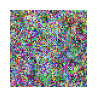

Epoch 11 | Loss: 0.2368447482585907 


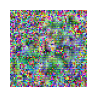

Epoch 12 | Loss: 0.23746773600578308 


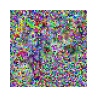

Epoch 13 | Loss: 0.24202659726142883 


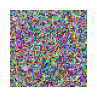

Epoch 14 | Loss: 0.2489035576581955 


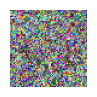

Epoch 15 | Loss: 0.22525940835475922 


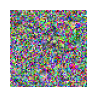

Epoch 16 | Loss: 0.23681482672691345 


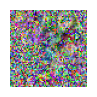

Epoch 17 | Loss: 0.23511028289794922 


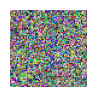

Epoch 18 | Loss: 0.24593965709209442 


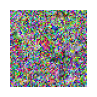

Epoch 19 | Loss: 0.2242453545331955 


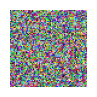

Epoch 20 | Loss: 0.23288419842720032 


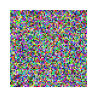

Epoch 21 | Loss: 0.2256721705198288 


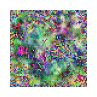

Epoch 22 | Loss: 0.20615553855895996 


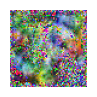

Epoch 23 | Loss: 0.21736407279968262 


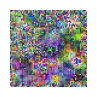

Epoch 24 | Loss: 0.20822927355766296 


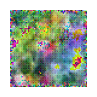

Epoch 25 | Loss: 0.21278804540634155 


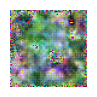

Epoch 26 | Loss: 0.2489054650068283 


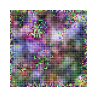

Epoch 27 | Loss: 0.2245839685201645 


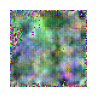

Epoch 28 | Loss: 0.19826176762580872 


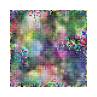

Epoch 29 | Loss: 0.22758762538433075 


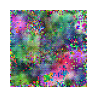

Epoch 30 | Loss: 0.22987768054008484 


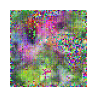

Epoch 31 | Loss: 0.20182082056999207 


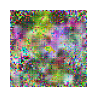

Epoch 32 | Loss: 0.20291128754615784 


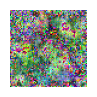

Epoch 33 | Loss: 0.20011937618255615 


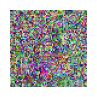

Epoch 34 | Loss: 0.18578128516674042 


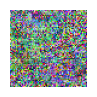

Epoch 35 | Loss: 0.2025664746761322 


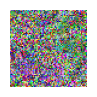

Epoch 36 | Loss: 0.2061007022857666 


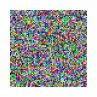

Epoch 37 | Loss: 0.21265196800231934 


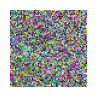

Epoch 38 | Loss: 0.18441925942897797 


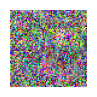

Epoch 39 | Loss: 0.20985250174999237 


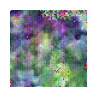

Epoch 40 | Loss: 0.18130874633789062 


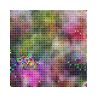

Epoch 41 | Loss: 0.17364612221717834 


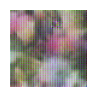

Epoch 42 | Loss: 0.20388071238994598 


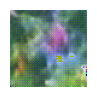

Epoch 43 | Loss: 0.19308379292488098 


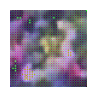

Epoch 44 | Loss: 0.17380627989768982 


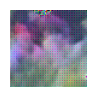

Epoch 45 | Loss: 0.20896375179290771 


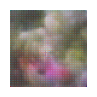

Epoch 46 | Loss: 0.18548575043678284 


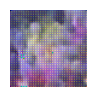

Epoch 47 | Loss: 0.18720316886901855 


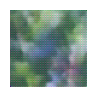

Epoch 48 | Loss: 0.18603044748306274 


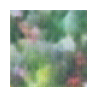

Epoch 49 | Loss: 0.19044575095176697 


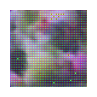

In [70]:
for epoch in range(50):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item()} ")
    sample_plot_image()

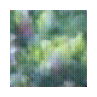

In [75]:
sample_plot_image()